In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os 
import osmnx as ox
import networkx as nx

In [2]:
# read csv into dataframe
df_all = pd.read_csv("df_all.csv")

In [3]:
# timestamps to datetime
df_all['iso_timestamp'] = pd.to_datetime(df_all['iso_timestamp'], utc=True, format='mixed')

# change columns to numerics
print(df_all.dtypes)
numeric_cols = [
    "channels_in", "channels_out", "channels_unknown", "channels_all", 
    "site_temperature", "site_rain_accumulation", "site_snow_accumulation"]

df_all[numeric_cols] = df_all[numeric_cols].apply(pd.to_numeric, errors='coerce')

df_all["count"] = df_all[["channels_out", "channels_in", "channels_unknown"]].fillna(0).sum(axis=1)


operator_name                          object
domain_name                            object
domain_id                               int64
counter_site                           object
counter_site_id                         int64
counter_serial                         object
longitude                             float64
latitude                              float64
timezone                               object
iso_timestamp             datetime64[ns, UTC]
channels_in                           float64
channels_out                          float64
channels_unknown                      float64
channels_all                            int64
site_temperature                      float64
site_rain_accumulation                float64
site_snow_accumulation                float64
dtype: object


In [4]:
# subset of dataframe just for one town 
df_domain = df_all[df_all["domain_name"] == "Landeshauptstadt Stuttgart"] # change domain name here for other towns
title_domain = df_domain["domain_name"].iloc[0]
print(title_domain)
df_domain_grouped = df_domain.groupby("counter_site")

# get coordinates for every counter site
domain_coords = {
    name: (
        df_domain_grouped.get_group(name)["latitude"].iloc[0],
        df_domain_grouped.get_group(name)["longitude"].iloc[0]
    )
    for name in df_domain_grouped.groups.keys()
}
domain_coords

Landeshauptstadt Stuttgart


{'Am Kräherwald': (np.float64(48.78424), np.float64(9.147031)),
 'Böblinger Straße': (np.float64(48.74661091153218),
  np.float64(9.13566226791684)),
 'Inselstraße': (np.float64(48.779637), np.float64(9.248607)),
 'Kirchheimer Straße': (np.float64(48.740003), np.float64(9.226692)),
 'Kremmlerstraße': (np.float64(48.739821), np.float64(9.152228)),
 'König-Karls-Brücke Barometer': (np.float64(48.79912609299229),
  np.float64(9.210372161982695)),
 'Lautenschlager Straße': (np.float64(48.78027), np.float64(9.17741)),
 'Neckartalstraße': (np.float64(48.826), np.float64(9.21488)),
 'Samaraweg': (np.float64(48.80808), np.float64(9.18554)),
 'Solitudestraße': (np.float64(48.80668681066975),
  np.float64(9.104345440864565)),
 'Stuttgarter Straße': (np.float64(48.8115094776975),
  np.float64(9.167497239565906)),
 'Taubenheimstraße': (np.float64(48.80490968434408),
  np.float64(9.226946272791574)),
 'Tübinger Straße': (np.float64(48.76976122395633),
  np.float64(9.172275119691044)),
 'Waiblinger 

In [5]:
# we need a reference latitude for the conversion
lat0 = np.mean([coord[0] for coord in domain_coords.values()])

# function to convert lat/lon to x/y in meters
def latlon_to_xy(coord, lat0=lat0):
    lat, lon = coord
    R = 6371000 # radius of earth in meters
    x = R * np.radians(lon) * np.cos(np.radians(lat0))
    y = R * np.radians(lat)
    return np.array([x, y])

# distance matrix
sites1 = list(domain_coords.keys())
dist_matrix_euclid = pd.DataFrame(index=sites1, columns=sites1, dtype=float)

# compute euclidean distances and fill the distance matrix
for a in sites1:
    for b in sites1:
        p1 = latlon_to_xy(domain_coords[a])
        p2 = latlon_to_xy(domain_coords[b])
        dist_matrix_euclid.loc[a, b] = np.linalg.norm(p1 - p2)

dist_matrix_euclid

,Am Kräherwald,Böblinger Straße,Inselstraße,Kirchheimer Straße,Kremmlerstraße,König-Karls-Brücke Barometer,Lautenschlager Straße,Neckartalstraße,Samaraweg,Solitudestraße,Stuttgarter Straße,Taubenheimstraße,Tübinger Straße,Waiblinger Straße,Waldburgstraße
Am Kräherwald,0.000000,4266.274727,7460.087575,7633.084501,4953.824082,4927.375407,2269.231997,6802.654899,3871.491563,4001.457984,3382.766567,6290.343210,2452.178635,6234.320832,8740.916462
Böblinger Straße,4266.274727,0.000000,9053.724554,6710.130191,1429.435223,8003.982737,4833.698653,10564.926507,7750.723753,7063.240861,7584.005331,9314.397664,3717.933494,9281.665453,4917.277002
Inselstraße,7460.087575,9053.724554,0.000000,4690.507815,8334.821109,3541.830156,5217.103710,5717.010265,5599.631780,10989.711924,6919.456983,3227.389561,5699.651169,3284.143243,13796.391437
Kirchheimer Straße,7633.084501,6710.130191,4690.507815,0.000000,5456.040636,6682.049846,5752.090694,9601.515855,8148.232280,11633.605596,9057.173346,7217.318051,5181.366080,7242.571340,10597.904841
Kremmlerstraße,4953.824082,1429.435223,8334.821109,5456.040636,0.000000,7850.867270,4861.469826,10625.465556,7972.850371,8221.311497,8049.522519,9074.881637,3638.835983,9052.800109,5468.723435
König-Karls-Brücke Barometer,4927.375407,8003.982737,3541.830156,6682.049846,7850.867270,0.000000,3198.296991,3006.440255,2074.057844,7813.972888,3429.988165,1374.165375,4295.755185,1324.979643,12914.112859
Lautenschlager Straße,2269.231997,4833.698653,5217.103710,5752.090694,4861.469826,3198.296991,0.000000,5778.762467,3149.183157,6106.390306,3548.791548,4547.538573,1227.598221,4507.027086,9728.300410
Neckartalstraße,6802.654899,10564.926507,5717.010265,9601.515855,10625.465556,3006.440255,5778.762467,0.000000,2931.201198,8378.791641,3827.434688,2506.251411,6989.327221,2458.651162,15385.743943
Samaraweg,3871.491563,7750.723753,5599.631780,8148.232280,7972.850371,2074.057844,3149.183157,2931.201198,0.000000,5951.170160,1375.900716,3054.264270,4370.298112,2981.644574,12504.005289
Solitudestraße,4001.457984,7063.240861,10989.711924,11633.605596,8221.311497,7813.972888,6106.390306,8378.791641,5951.170160,0.000000,4658.124786,8985.178685,6452.251991,8914.434615,10113.670672


In [29]:
# compute median of lats and lons for center point
lats = [coord[0] for coord in domain_coords.values()]
cp_lat = np.median(lats)

lons = [coord[1] for coord in domain_coords.values()]
cp_lon = np.median(lons)

# set median as center point 
center_point = (cp_lat, cp_lon)  

# access streetmaps graph with bike lanes, with median cp and 6km radius (adjust if needed)
G = ox.graph_from_point(center_point, dist=10000, network_type='bike')

In [30]:
# nodes in our graph are our counter sites 
snapped_nodes = {}
for name, (lat, lon) in domain_coords.items():
    node = ox.distance.nearest_nodes(G, X=lon, Y=lat)
    snapped_nodes[name] = node

In [31]:
# now name the nodes and compute shortest distance by bike
distances1 = {}
for i in snapped_nodes:
    for j in snapped_nodes:
        if (j, i) in distances1:
            distances1[(i, j)] = distances1[(j, i)]
            continue
        if i == j:
            distances1[(i, j)] = 0
            continue
        d = nx.shortest_path_length(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        distances1[(i, j)] = d
        print(f"distance between {i} and {j}: {d:.1f} m")


distance between Am Kräherwald and Böblinger Straße: 6406.0 m
distance between Am Kräherwald and Inselstraße: 9403.2 m
distance between Am Kräherwald and Kirchheimer Straße: 9735.0 m
distance between Am Kräherwald and Kremmlerstraße: 6955.3 m
distance between Am Kräherwald and König-Karls-Brücke Barometer: 7021.3 m
distance between Am Kräherwald and Lautenschlager Straße: 3033.7 m
distance between Am Kräherwald and Neckartalstraße: 8150.3 m
distance between Am Kräherwald and Samaraweg: 4500.0 m
distance between Am Kräherwald and Solitudestraße: 5255.5 m
distance between Am Kräherwald and Stuttgarter Straße: 3899.6 m
distance between Am Kräherwald and Taubenheimstraße: 7755.9 m
distance between Am Kräherwald and Tübinger Straße: 3859.1 m
distance between Am Kräherwald and Waiblinger Straße: 7770.2 m
distance between Am Kräherwald and Waldburgstraße: 10432.1 m
distance between Böblinger Straße and Inselstraße: 11765.2 m
distance between Böblinger Straße and Kirchheimer Straße: 8487.3 m
d

In [32]:
# compute all the routes as well and store them in a dict
# you can plot it too! (uncomment last line, do not recommend it for stuttgart though)
routes = {}

keys = list(snapped_nodes.keys())

for i in keys:
    for j in keys:
        if (j, i) in routes:
            routes[(i, j)] = routes[(j, i)]
            continue
        if i == j:
            routes[(i, j)] = [snapped_nodes[i]]
            continue
        r = nx.shortest_path(G, snapped_nodes[i], snapped_nodes[j], weight='length')
        routes[(i, j)] = r
        #ox.plot_graph_route(G, r)



- Heidelberg: 15 counter
- Stuttgart: 15 counter
- Ludwigsburg: 15 counter
- Mannheim: 14 counter
- Freiburg: 10 counter
- Reutlingen: 7 counter
- Konstanz: 6 counter
- Tübingen: 5 counter
- Heilbronn: 4 counter
- Lörrach: 2 counter


In [33]:
# pivot table for correlation matrix
df_domain_pivot = df_domain.pivot_table(
    index = 'iso_timestamp',
    columns = 'counter_site',
    values = 'count',
    aggfunc='sum'
)

# we want to see how many timestamps have data for both sites
mask = df_domain_pivot.notna().astype(int)
overlap = mask.T.dot(mask)
overlap

counter_site,Am Kräherwald,Böblinger Straße,Inselstraße,Kirchheimer Straße,Kremmlerstraße,König-Karls-Brücke Barometer,Lautenschlager Straße,Neckartalstraße,Samaraweg,Solitudestraße,Stuttgarter Straße,Taubenheimstraße,Tübinger Straße,Waiblinger Straße,Waldburgstraße
counter_site,,,,,,,,,,,,,,,
Am Kräherwald,45221,45171,45221,45221,45221,45182,45221,45221,45209,45221,45221,45185,45220,45183,45221
Böblinger Straße,45171,103524,45626,45171,45171,103519,46016,45171,46836,45171,45171,77679,45998,77679,46000
Inselstraße,45221,45626,45676,45221,45221,45637,45676,45221,45664,45221,45221,45640,45675,45638,45676
Kirchheimer Straße,45221,45171,45221,45221,45221,45182,45221,45221,45209,45221,45221,45185,45220,45183,45221
Kremmlerstraße,45221,45171,45221,45221,45221,45182,45221,45221,45209,45221,45221,45185,45220,45183,45221
König-Karls-Brücke Barometer,45182,103519,45637,45182,45182,112278,46027,45182,46847,45182,45182,77690,46009,77690,46011
Lautenschlager Straße,45221,46016,45676,45221,45221,46027,46066,45221,46054,45221,45221,46030,46048,46028,46050
Neckartalstraße,45221,45171,45221,45221,45221,45182,45221,45221,45209,45221,45221,45185,45220,45183,45221
Samaraweg,45209,46836,45664,45209,45209,46847,46054,45209,46886,45209,45209,46850,46036,46848,46038


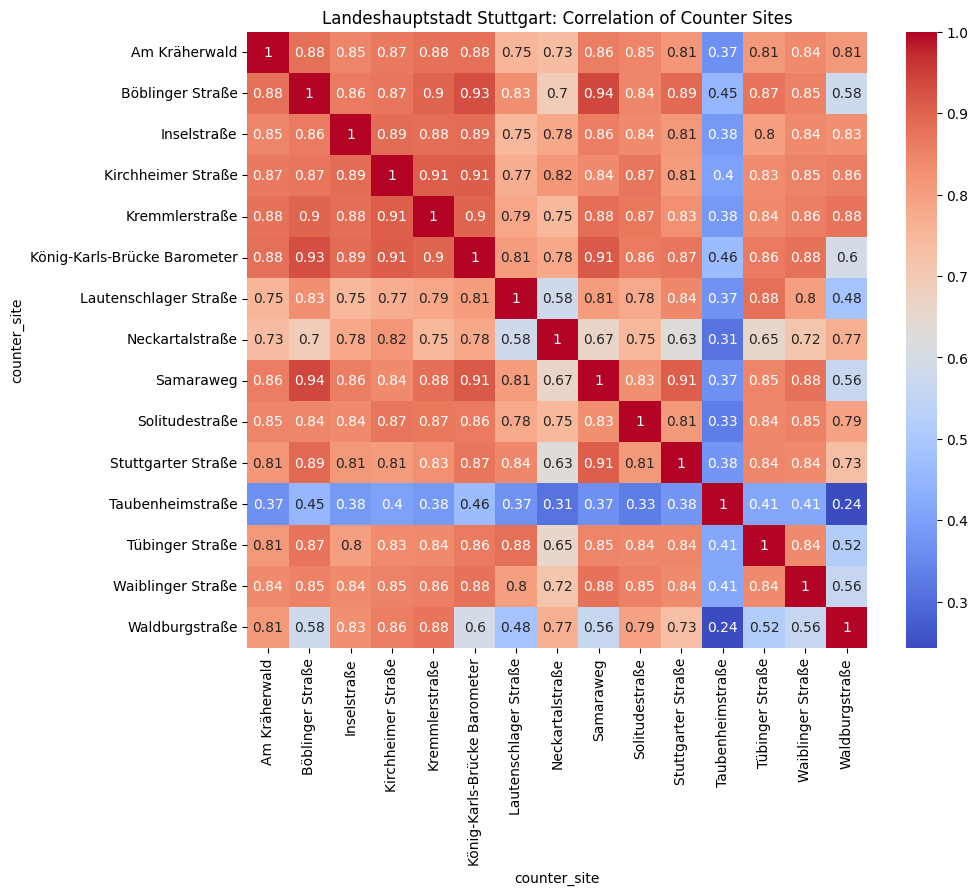

In [34]:
# compute correlation matrix and plot heatmap
# this shows correlation of counter sites based on their counts
corr_matrix = df_domain_pivot.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Correlation of Counter Sites")
plt.show()

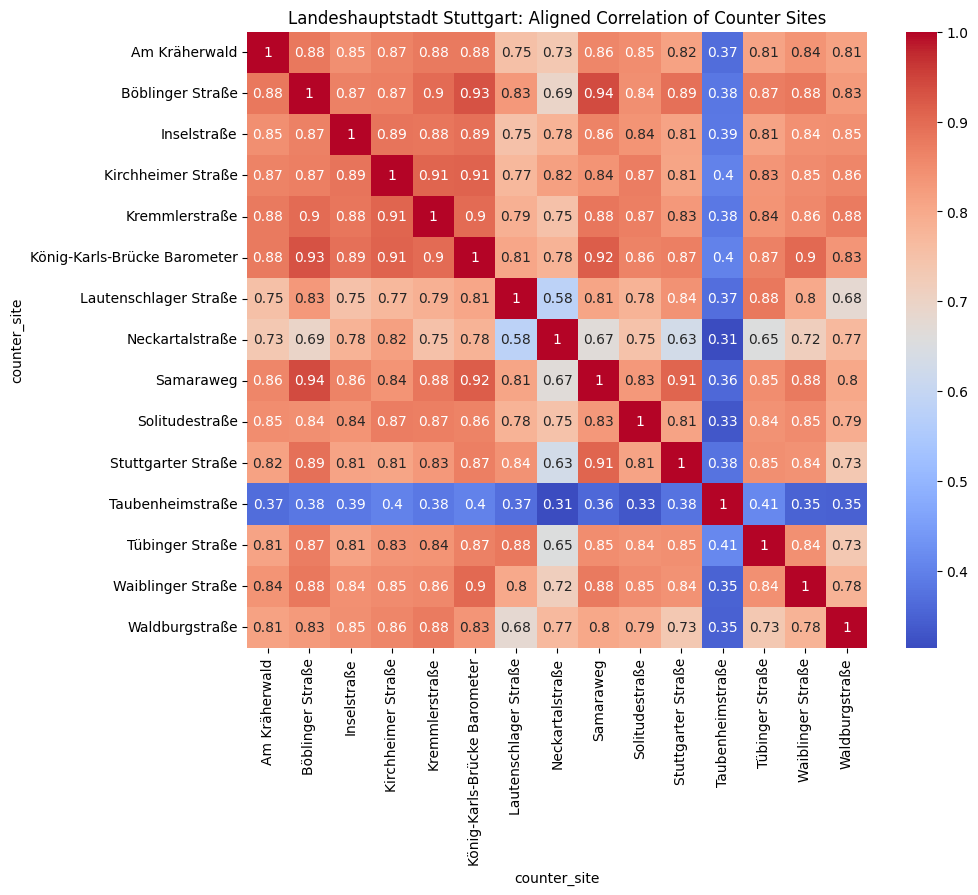

In [35]:
# correlation matrix for just times where all sites have data
# maybe more meaningful, still not sure
aligned = df_domain_pivot.dropna()
corr_matrix1 = aligned.corr()
plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix1, annot=True, cmap='coolwarm')
plt.title(f"{title_domain}: Aligned Correlation of Counter Sites")
plt.show()

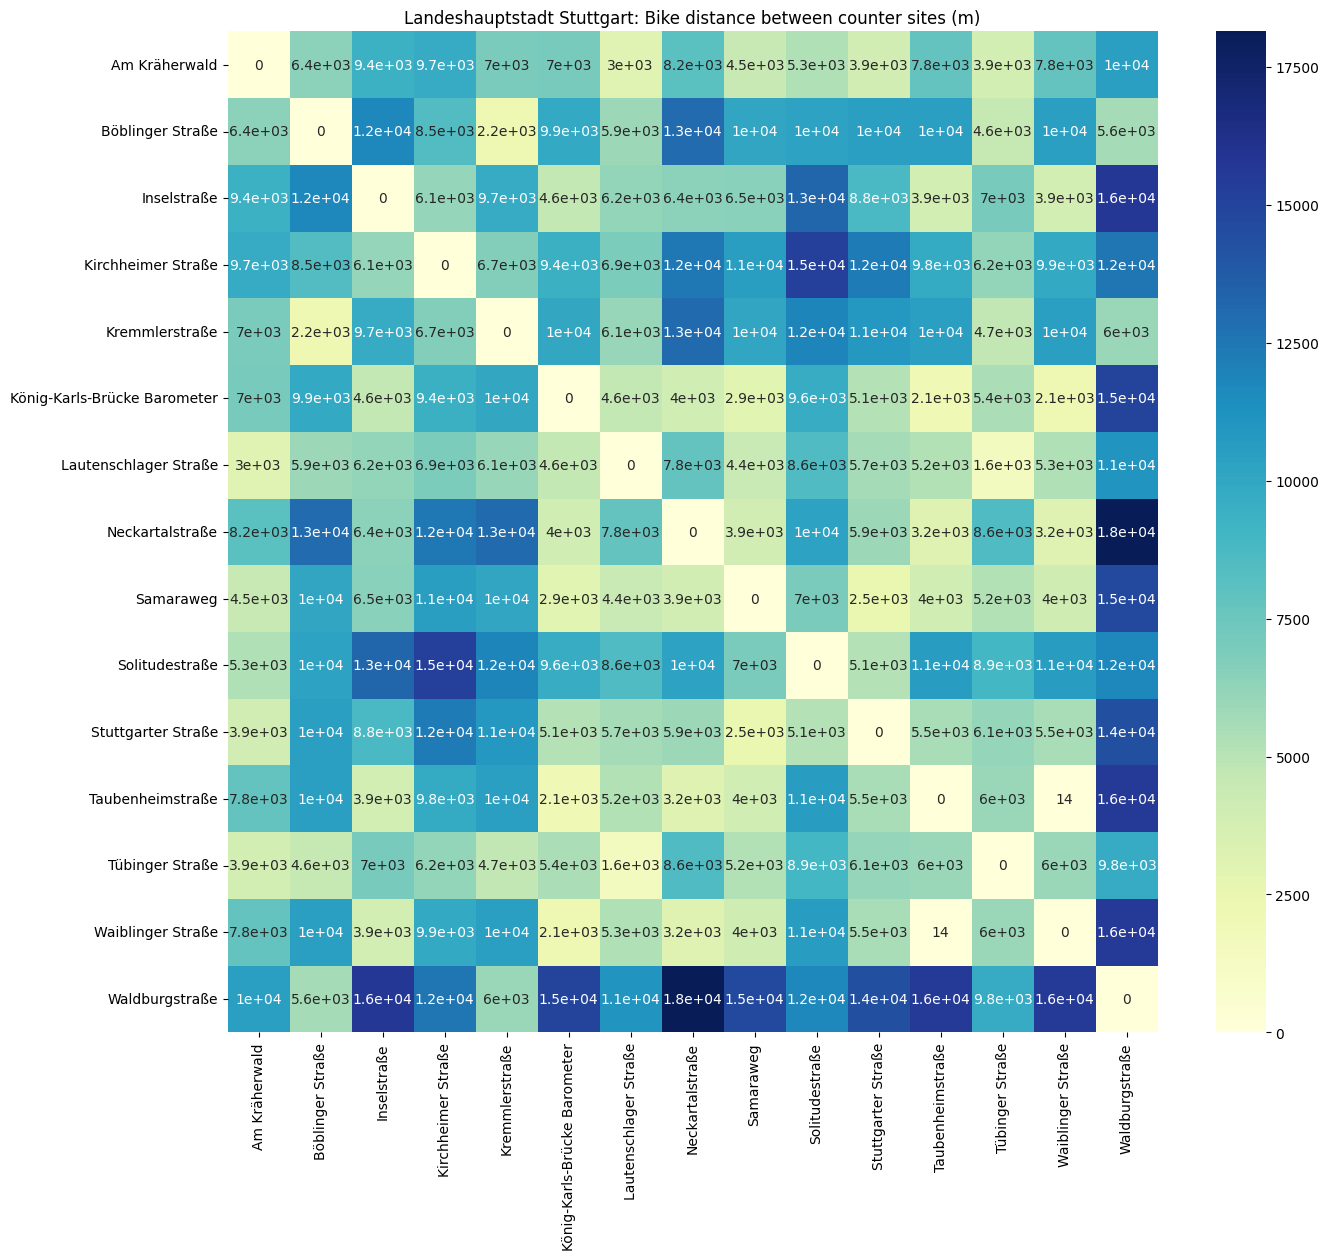

In [36]:
# now we want matrices for distances
# create distance matrix (for bike dist)
dist_matrix = pd.DataFrame(index=sites1, columns=sites1)
for (site1, site2), dist in distances1.items():
    dist_matrix.loc[site1, site2] = dist
    dist_matrix.loc[site2, site1] = dist

# fill diagonal with 0
dist_matrix.fillna(0, inplace=True)

# check shape
dist_matrix.shape

# heatmap for distances 
plt.figure(figsize=(15,13))
sns.heatmap(dist_matrix.astype(int), annot=True, cmap='YlGnBu')
plt.title(f"{title_domain}: Bike distance between counter sites (m)")
plt.show()  

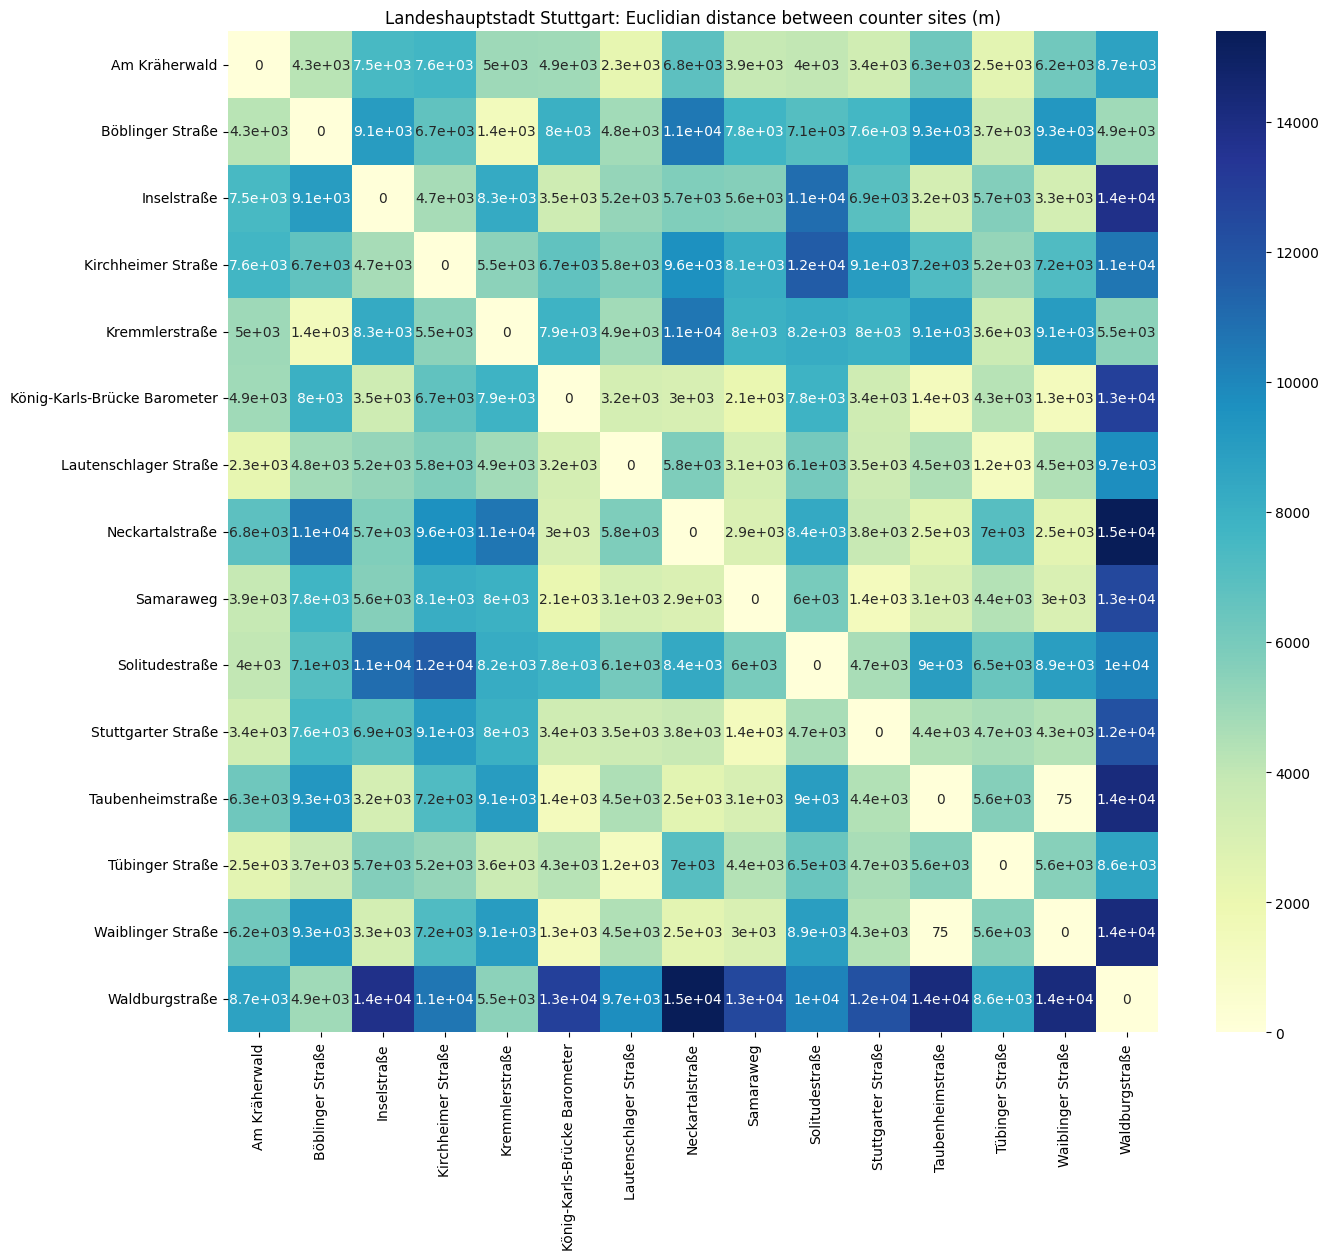

In [37]:
# now again for euclidian distances (we computed matrix already above)
plt.figure(figsize=(15,13))
sns.heatmap(dist_matrix_euclid.astype(float), annot=True, cmap='YlGnBu')
plt.title(f"{title_domain}: Euclidian distance between counter sites (m)")
plt.show()

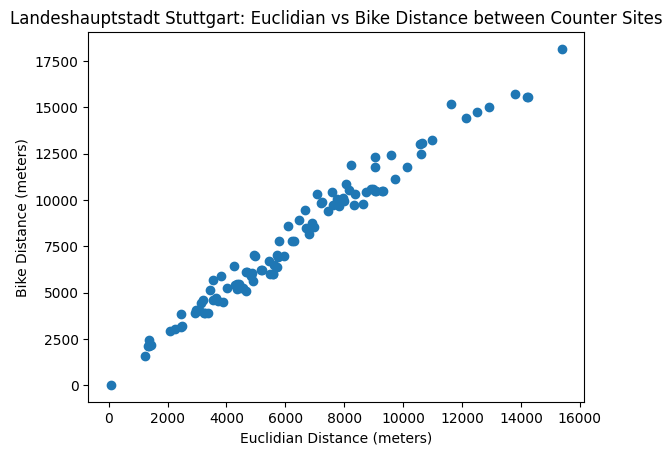

In [38]:
# euclidian vs bike distance scatter plot
euclidian_distances = []
bike_distances = []
for site_a in sites1:
    for site_b in sites1:
        if site_a >= site_b:
            continue
        euclidian_distances.append(dist_matrix_euclid.loc[site_a, site_b])
        bike_distances.append(dist_matrix.loc[site_a, site_b])
plt.scatter(euclidian_distances, bike_distances)
plt.xlabel("Euclidian Distance (meters)")
plt.ylabel("Bike Distance (meters)")
plt.title(f"{title_domain}: Euclidian vs Bike Distance between Counter Sites")
plt.show()

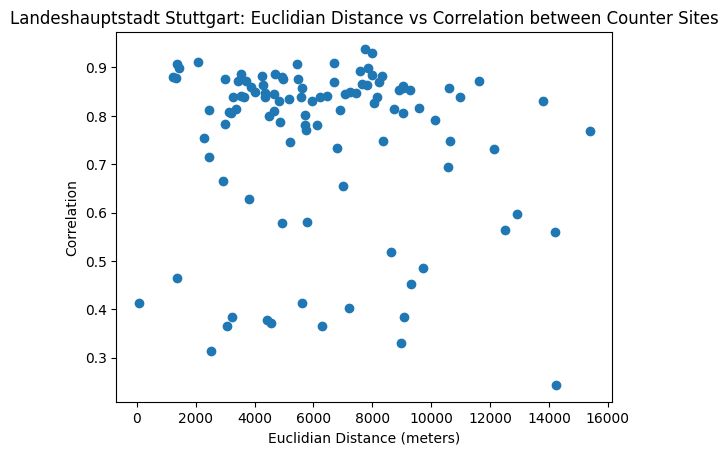

In [39]:
# euclidian distance vs correlation plot
# using euclidian distance and unaligned correlation
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix_euclid.loc[site1, site2]
        correlation = corr_matrix.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)

plt.scatter(distance_values, correlations)
plt.xlabel("Euclidian Distance (meters)")
plt.ylabel("Correlation")
plt.title(f"{title_domain}: Euclidian Distance vs Correlation between Counter Sites")
plt.show()

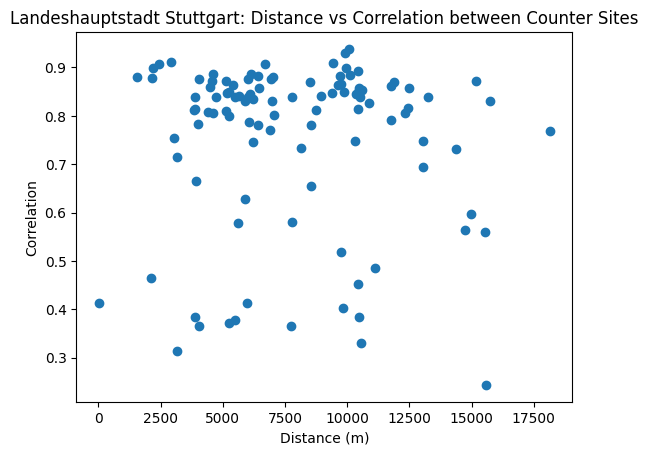

In [40]:
# distance vs correlation plot
# using bike distance and unaligned correlation
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix.loc[site1, site2]
        correlation = corr_matrix.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)


plt.scatter(distance_values, correlations)
plt.xlabel("Distance (m)")
plt.ylabel("Correlation")
plt.title(f"{title_domain}: Distance vs Correlation between Counter Sites")
plt.show()

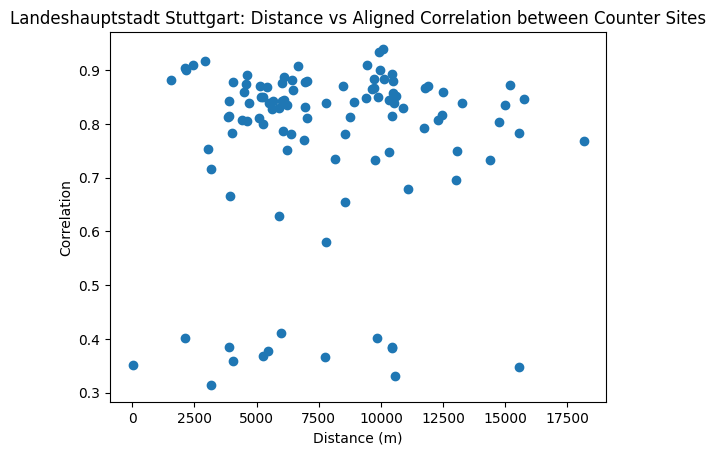

In [41]:
# distance vs correlation plot
# using bike distance and aligned correlation
correlations = []
distance_values = []
for i in range(len(sites1)):
    for j in range(i + 1, len(sites1)):
        site1 = sites1[i]
        site2 = sites1[j]
        distance = dist_matrix.loc[site1, site2]
        correlation = corr_matrix1.loc[site1, site2]
        distance_values.append(distance)
        correlations.append(correlation)


plt.scatter(distance_values, correlations)
plt.xlabel("Distance (m)")
plt.ylabel("Correlation")
plt.title(f"{title_domain}: Distance vs Aligned Correlation between Counter Sites")
plt.show()